In [1]:
import json
import os
from copy import deepcopy
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda" 
elif torch.backends.mps.is_available():
    device = "mps"
print(f"Using {device} device")

Using cuda device


## dataset

In [20]:
infile = '/home/yuan/results/epitope/combined_ann.txt'
vdf = pd.read_csv(infile, header=0, index_col=False, sep='\t')
vdf.head()

,seq,label,pred_ann,pred_wann
0,RPIAEYLNTQKDM,epitope,0.636172,0.761304
1,ARFDSVFGK,epitope,0.707062,0.892763
2,ARFDSVFGKF,epitope,0.796207,0.940239
3,ARFDSVFGKFL,epitope,0.838309,0.954055
4,DAFVAYHI,epitope,0.644262,0.837522


## load RNN model

In [8]:
from my_collate import MyCollate

input_vocab = torch.load('../models/epitopes_rnn_input_vocab.pth')
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

In [9]:
model = torch.load('../models/epitopes_rnn_model.pth')
model.eval()

MyRnn(
  (embedding): Embedding(26, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [10]:
from my_process import MyProcess

p = MyProcess(model, collate_fn)

In [11]:
# test model
input = [
    # epitope
    'SSPFLKGFLAGYVVAKLRASAV', 
    # other seq
    'AELMPVGDNN',
    # wrong seq
    'AXAXAXAXA',
]
pred = p.predict(input)
pred

,text,predict
0,SSPFLKGFLAGYVVAKLRASAV,0.987687
1,AELMPVGDNN,0.125607
2,AXAXAXAXA,0.885124


In [37]:
# predict using entire dataset
pred = []
chunks = np.array_split(np.array(vdf['seq']), 100)
for chunk in chunks:
    pred1 = p.predict(chunk)
    pred.extend(pred1['predict'])
# 
print(df.shape, len(pred))
vdf['pred_rnn'] = pred

(4980441, 2) 3182867


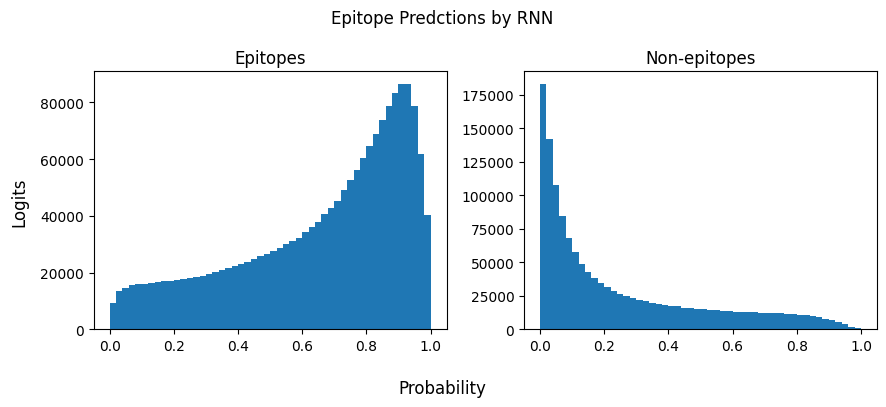

In [39]:
# 
fig, ax = plt.subplots(1,2, figsize=(9,4),layout='tight')
fig.suptitle('Epitope Predctions by RNN')
fig.supxlabel('Probability')
fig.supylabel('Logits')

i=0
ax[i].hist(vdf[vdf['label']=='epitope']['pred_rnn'], bins=50)
ax[i].set_title('Epitopes')

i=1
ax[i].hist(vdf[~(vdf['label']=='epitope')]['pred_rnn'], bins=50)
ax[i].set_title('Non-epitopes')

plt.show()

In [40]:
# export
vdf.head()
outfile = '/home/yuan/results/epitope/combined_ann_rnn.txt'
vdf.to_csv(outfile, header=True, index=False, sep='\t')